In [1]:
from google.colab import drive 
drive.mount('/gdrive') # 구글드라이브 연결

Mounted at /gdrive


In [2]:
import zipfile as zf
files = zf.ZipFile("/gdrive/My Drive/Colab Notebooks/onlyimagedata.zip",'r') # 압축 파일의 자료 읽기
files.extractall()
files.close()

In [3]:
# 폴더명 기준으로 라벨구분분
import os

labels = os.listdir(r'/content/data') 
print('라벨:', labels)

라벨: ['vin', 'paper', 'styro', 'plastic', 'can', 'pet']


In [4]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# 각 라벨마다 train, val 파일 생성 및 데이터 나누기
import splitfolders

os.mkdir("/content/data_new")
splitfolders.ratio('/content/data', output="/content/data_new", seed=77, ratio=(0.8, 0.2))

Copying files: 60000 files [00:16, 3727.40 files/s]


In [6]:
!pip install torch
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용가능 여부 확인

In [8]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체를 train, val 별로 지정
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),  # 데이터를 tensor로 바꿔준다
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)작업, PyTorch 기본값으로 셋팅
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
# 지정한 변형 객체를 저장
data_dir = '/content/data_new'

train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
val_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'), transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=4, shuffle=True, num_workers=2)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(val_datasets))

class_names = train_datasets.classes
print('라벨:', class_names)

학습 데이터셋 크기: 48000
테스트 데이터셋 크기: 12000
라벨: ['can', 'paper', 'pet', 'plastic', 'styro', 'vin']


In [10]:
# pytorch에서 미리 훈련된 모델 가져오기

model = models.resnet34(pretrained=True)
num_features = model.fc.in_features

# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 라벨수만큼 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [11]:
# 학습 진행

num_epochs = 10
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # train_dataloader를 이용해 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # optimizer로 모델 파라미터 업데이트, 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()# 기울기 값 초기화
        outputs = model(inputs) 
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels) #criterion로 예측값과 실제 정답이 동일한지 확인인

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.5719 Acc: 80.6750% Time: 524.2867s
#1 Loss: 0.3129 Acc: 89.4771% Time: 1028.6828s
#2 Loss: 0.2293 Acc: 92.2146% Time: 1543.7693s
#3 Loss: 0.1884 Acc: 93.4312% Time: 2059.0293s
#4 Loss: 0.1561 Acc: 94.5437% Time: 2566.5750s
#5 Loss: 0.1307 Acc: 95.4271% Time: 3071.1003s
#6 Loss: 0.1115 Acc: 96.2208% Time: 3579.4151s
#7 Loss: 0.0942 Acc: 96.7438% Time: 4085.6834s
#8 Loss: 0.0819 Acc: 97.1854% Time: 4591.8288s
#9 Loss: 0.0691 Acc: 97.6292% Time: 5100.8079s


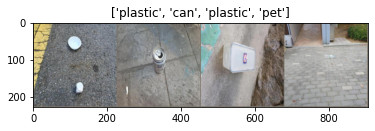

In [15]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [20]:
model.eval() # 모델 평가
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in val_dataloader: #평가 데이터 이용
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_datasets)
    epoch_acc = running_corrects / len(val_datasets) * 100.
    print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))
     

[Test] Loss: 0.1969 Acc: 93.7833% Time: 56.6686s


In [ ]:
# 시각화?  훈련 시의 epoch_loss, epoch_acc와 평가 시의 epoch_loss, epoch_acc plt를 비교하는 그래프 그려보기..